![DBC](Images/DBC.png)

# Scholar Metrics Scraper: ScholarScraper notebook

**Introduction**

This notebook automates the process of retrieving bibliometric data from Google Scholar for a list of authors. It utilizes [scholarly](https://pypi.org/project/scholarly/), a Python module that allows users to retrieve bibliometrics from [Google Scholar](https://scholar.google.ca/). It also creates a citations/year bar chart and a collaborations heatmap. This notebook should be run before the ScholarCollabs and GroupedCollabs notebooks.

This project currently works with scholarly 1.4.5

**Installation and Setup**

1. Set-up Jupyter. If your institution has access, you can use [Syzygy](https://syzygy.ca/) to run in the Cloud, or install on your computer following [these instructions](https://jupyter.org/install).
2. Clone the project.
    - Open Terminal (in Syzygy, click the "+" button to open a new launcher and click "Terminal"
    - Type  "git clone https://github.com/ubcbraincircuits/scholar_metrics_scraper" and press enter
    - The project should now be cloned in your directory. 
    - Alternatively, you can download the project as a ZIP file from https://github.com/ubcbraincircuits/scholar_metrics_scraper(click Code, then Download ZIP)
3. [Install scholarly](https://pypi.org/project/scholarly/)
    - In the terminal (from above) type "pip install scholarly" or "pip install --user scholarly" and press enter
4. Obtain a CSV file with the list of author names in a single column with no column header. Ideally, all author names should match their names in Google Scholar. Upload this file to Syzygy or move it to the project folder on your computer. This file should be in the same directory as this notebook file (ScholarScraper.ipynb). 
5. Modify the names of the input/output files below (in step 2). The input file name must match the CSV file name. 
6. Modify the "affiliations" variable as a list of institution names which the researchers are affiliated with. Include both abbreviated and long form.  
7. Run all cells (click shift+enter to run a cell or the play button above). 
8. Open the ouput CSV file in the same directory as this notebook file. Check the last column of this file for warnings. If needed, modify the author names in the input CSV file if the wrong author profile was scraped, or no profile was found, and re-run.


**Steps**

1. Install and load libraries and packages.


In [1]:
# from scholarly import ProxyGenerator
# pg = ProxyGenerator()

In [1]:

#If you receive an error running this cell for the first time, try running it agian. 

import csv
import warnings
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm as CM

from time import sleep
from pybliometrics.scopus import CitationOverview, AuthorRetrieval, AbstractRetrieval
from pybliometrics.scopus.utils import config
config['Authentication'] ['APIKey'] = "127f5bf5de20d338f686704a9a328b86"
print(config['Authentication'] ['APIKey'])

127f5bf5de20d338f686704a9a328b86


2. Modify the names of the input and output files. The name of the input file should match the name of the author list CSV file. If you followed the setup instructions, the CSV file should now be in the same directory as this notebook file. The output file does not have to exist yet (it will be created). 

In [2]:
# !!! Modify this to match the name of your author list CSV file. 
author_list_csv = "authorlist comparisons/scival_outputs/scival_ids_authorlist_official.csv"
output_data_csv = "sv_authorlist_publications_updated3.csv"

#note data stored in csv columns
lastname_col_idx = 0 
firstname_col_idx = 1
id_col_idx = 2 

bargraph_output = "sv_authorlist_citations_updated1.pdf"
figure_output = "sv_authorlist_heatmap_updated1.pdf"

3. Load in the author names from the CSV file. 

In [4]:
author_rows= []
with open(author_list_csv, encoding ="utf-8-sig") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter =',')
    for row in csv_reader:
        if row[0] != "":
            author_rows.append(row)

author_rows = author_rows[1:]

print("first row:", author_rows[0])
try:
    author_names = [row for row in author_rows if row[id_col_idx] != "" and int(row[id_col_idx])]
except ValueError:
    raise ValueError("make sure the index of the column ID from member array is valid!")
            

first row: ['Murphy', 'Timothy H.', '7401632487']


4. Modify the affiliations list with institutions which the researchers are affiliated with. 

In [5]:
affiliations = ['University of British Columbia', 'UBC', 'Djavad Mowafaghian', 'Simon Fraser University', 'University of Victoria', 'University of Washington']

5. Scrape data for each author. This will take several minutes. 

In [6]:
# This will contain all the data for each author which will be exported as a table. It will be a list of dictionaries. 
rows = []
# This will contain a list of dictionaries for each author. The dictionaries will be made up of years as keys and citation numbers as vals
cites_per_year = []
# This dictionary will contain publication titles as keys and author names as values
pub_authors = {}


for athr in author_names:
    sleep(1)
    used_athr_ID = False
    # author_name = f"{athr[firstname_col_idx]} {athr[lastname_col_idx]}"
    scopus_id = athr[id_col_idx]
    
    pubs = []
    try :
        ar = AuthorRetrieval(scopus_id)
        documents = ar.get_documents()
        author_name = f"{ar.given_name} {ar.surname}"
    except (RuntimeError,TypeError,StopIteration):
        row = {'Name': author_name, 'Warning': 'no information found'}
    else:
        # Get publications titles 
        for document in documents:
            pubs.append(document.title)
            # Add to dictionary with title as key and author as value
            pub_authors.setdefault(document.title, []).append(author_name)
        
        # Create row (dictionary) for output data table
        # row = {'Name': data_dict['name'], 'Scholar ID': data_dict['scholar_id'], 
        #        'Cited by': data_dict.get('citedby', ''), 'Cited by 5 years': data_dict.get('citedby5y',''), 
        #        'h-index': data_dict.get('hindex',''), 'h-index 5 years': data_dict.get('hindex5y',''), 
        #        'i10-index': data_dict.get('i10index',''),'i10-index 5 years': data_dict.get('i10index5y',''), 
        #        '"Publications"': pubs, 'Document Count': len(pubs), 'Affiliation': data_dict['affiliation']}
        
        row = {'Name': author_name, 
               'Author ID': scopus_id,
               'Cited by': ar.citation_count,
            #    '"Publications"': pubs,
               'Document Count': ar.document_count,
               'Affiliation':ar.affiliation_current[0].preferred_name}
        
        # Create list of authors who do not have the specified affiliation

        if used_athr_ID == False and not any(ar.affiliation_current[0].preferred_name):
            row['Warning'] = "Affiliation does not match!"
            
    finally:    
        rows.append(row)
        used_athr_ID = False

                

6. Add coauthors to the rows. 

In [11]:
# Create dictionary with author names as keys and dictionary (coauthor name as key, number of collaborations as value) 
#   as value
collabs_dict={}
for key in pub_authors:
    for author in pub_authors[key]:
        for coauthor in pub_authors[key]:
            if coauthor is not author:
                if author not in collabs_dict.keys() or coauthor not in collabs_dict[author].keys():
                    collabs_dict.setdefault(author,{})[coauthor]=1
                else:
                    collabs_dict[author][coauthor]+=1


# Write to rows dataframe
for row in rows:
    if row['Name'] in collabs_dict.keys():
        row['Coauthors'] = collabs_dict[row['Name']]

        

In [15]:


coauthored_pubs = [
    title
    for title, authors in pub_authors.items() 
    if len(authors) > 1]

coauthored_authors = [
    authors
    for title, authors in pub_authors.items() 
    if len(authors) > 1]

coauthored_df = pd.DataFrame({"Title": coauthored_pubs, "Authors": coauthored_authors})

print(coauthored_df.head())

coauthored_df.to_csv("shared_pubs.csv",index=False)

                                               Title  \
0  Chronic multiscale resolution of mouse brain n...   
1  Water-Reaching Platform for Longitudinal Asses...   
2  Multiscale imaging informs translational mouse...   
3  Towards a Visualizable, De-identified Syntheti...   
4  Altered cortical processing of sensory input i...   

                                             Authors  
0           [Timothy H. Murphy, Lynn Alison Raymond]  
1           [Timothy H. Murphy, Lynn Alison Raymond]  
2              [Timothy H. Murphy, Jeffrey M. LeDue]  
3  [Timothy H. Murphy, Timothy H. Murphy, Helge R...  
4           [Timothy H. Murphy, Lynn Alison Raymond]  


7. Write rows to output CSV file

In [14]:
# Specify the order of the data. These keys must match the names of the keys in the rows dictionary. 
# keys = ['Name', 'Scholar ID', 'Document Count', 'Cited by', 'Cited by 5 years', 'h-index', 'h-index 5 years',  'i10-index', 'i10-index 5 years', 'Publications', 'Coauthors', 'Affiliation', 'Warning']
keys = ['Name', 
        'Author ID',
        'Cited by',
        'Document Count',
        'Coauthors',
        'Affiliation']

# This creates/opens the file with filename with the intention to write to the csv_file
# The encoding allows the characters to be properly written to the csv_file
with open(output_data_csv, mode='w', encoding ="utf-8") as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    dict_writer = csv.DictWriter(csv_file, keys, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    dict_writer.writeheader()
    dict_writer.writerows(rows)



8. Create barplot of citations per year. Modify the years and output PDF filename. 

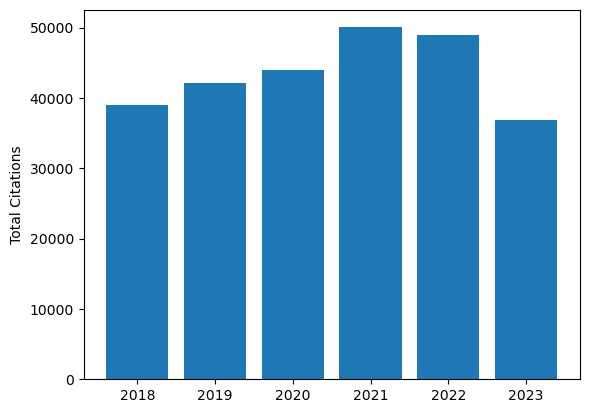

In [18]:
# Create citations per year dataframe
cites_df = pd.DataFrame(cites_per_year)

# Add a totals column
cites_df.loc['Total']= cites_df.sum()

# Select years to plot
cites_df_selected = cites_df[[2018,2019,2020,2021,2022,2023]]

# Select the last row (totals) 
cites_df_total = cites_df_selected.iloc[-1:]

# Create barplot
years = list(cites_df_total.columns)
cites = cites_df_total.values.tolist()[0]
plt.bar(years, cites )
plt.ylabel('Total Citations')

# !!! Modify this - name the output PDF file
plt.savefig(bargraph_output)

9. Create collaboration heatmap

['Timothy H. Murphy', 'Lynn Alison Raymond', 'Jeffrey M. LeDue', 'Helge Rhodin', 'Brian Archibald MacVicar', 'Yu Tian Wang', 'Wolfram G. Tetzlaff', 'Craig E. Brown', 'Andy Y. Shih', 'Terrance P. Snutch', 'Silke Appel-Cresswell', 'Leigh Anne Swayne', 'Shernaz X. Bamji', 'Anthony G. Phillips', 'Fidel Vila-Rodriguez', 'Sophia Frangou', 'Ian R. Mackenzie', 'Jason S. Snyder', 'Z. Jane Wang', 'Kurt Z. Haas', 'Paul Pavlidis', 'Catharine H. Rankin', 'Lara A. Boyd', 'Liisa A.M. Galea', 'Martin J. McKeown', 'A. Jon Stoessl', 'Vesna Sossi', 'Todd Stephen Woodward', 'Peyman Servati', 'P. A. Cripton', 'Angela Jane I. Roskams', 'Fabio M.V. Rossi', 'Jeremy Keith Seamans', 'Catharine A. Winstanley', 'Leonid Sigal', 'Brian D. Fisher', 'Purang Abolmaesumi', 'Adrienne L. Fairhall', 'Eric T. Shea-Brown', 'Ilker Hacihaliloglu']


C:\Users\caoyut\AppData\Local\Temp\ipykernel_10576\1280417698.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = CM.get_cmap('nipy_spectral')
c:\Users\caoyut\.conda\envs\sms\lib\site-packages\fontTools\misc\py23.py:11: DeprecationWarning: The py23 module has been deprecated and will be removed in a future release. Please update your code.
  warnings.warn(


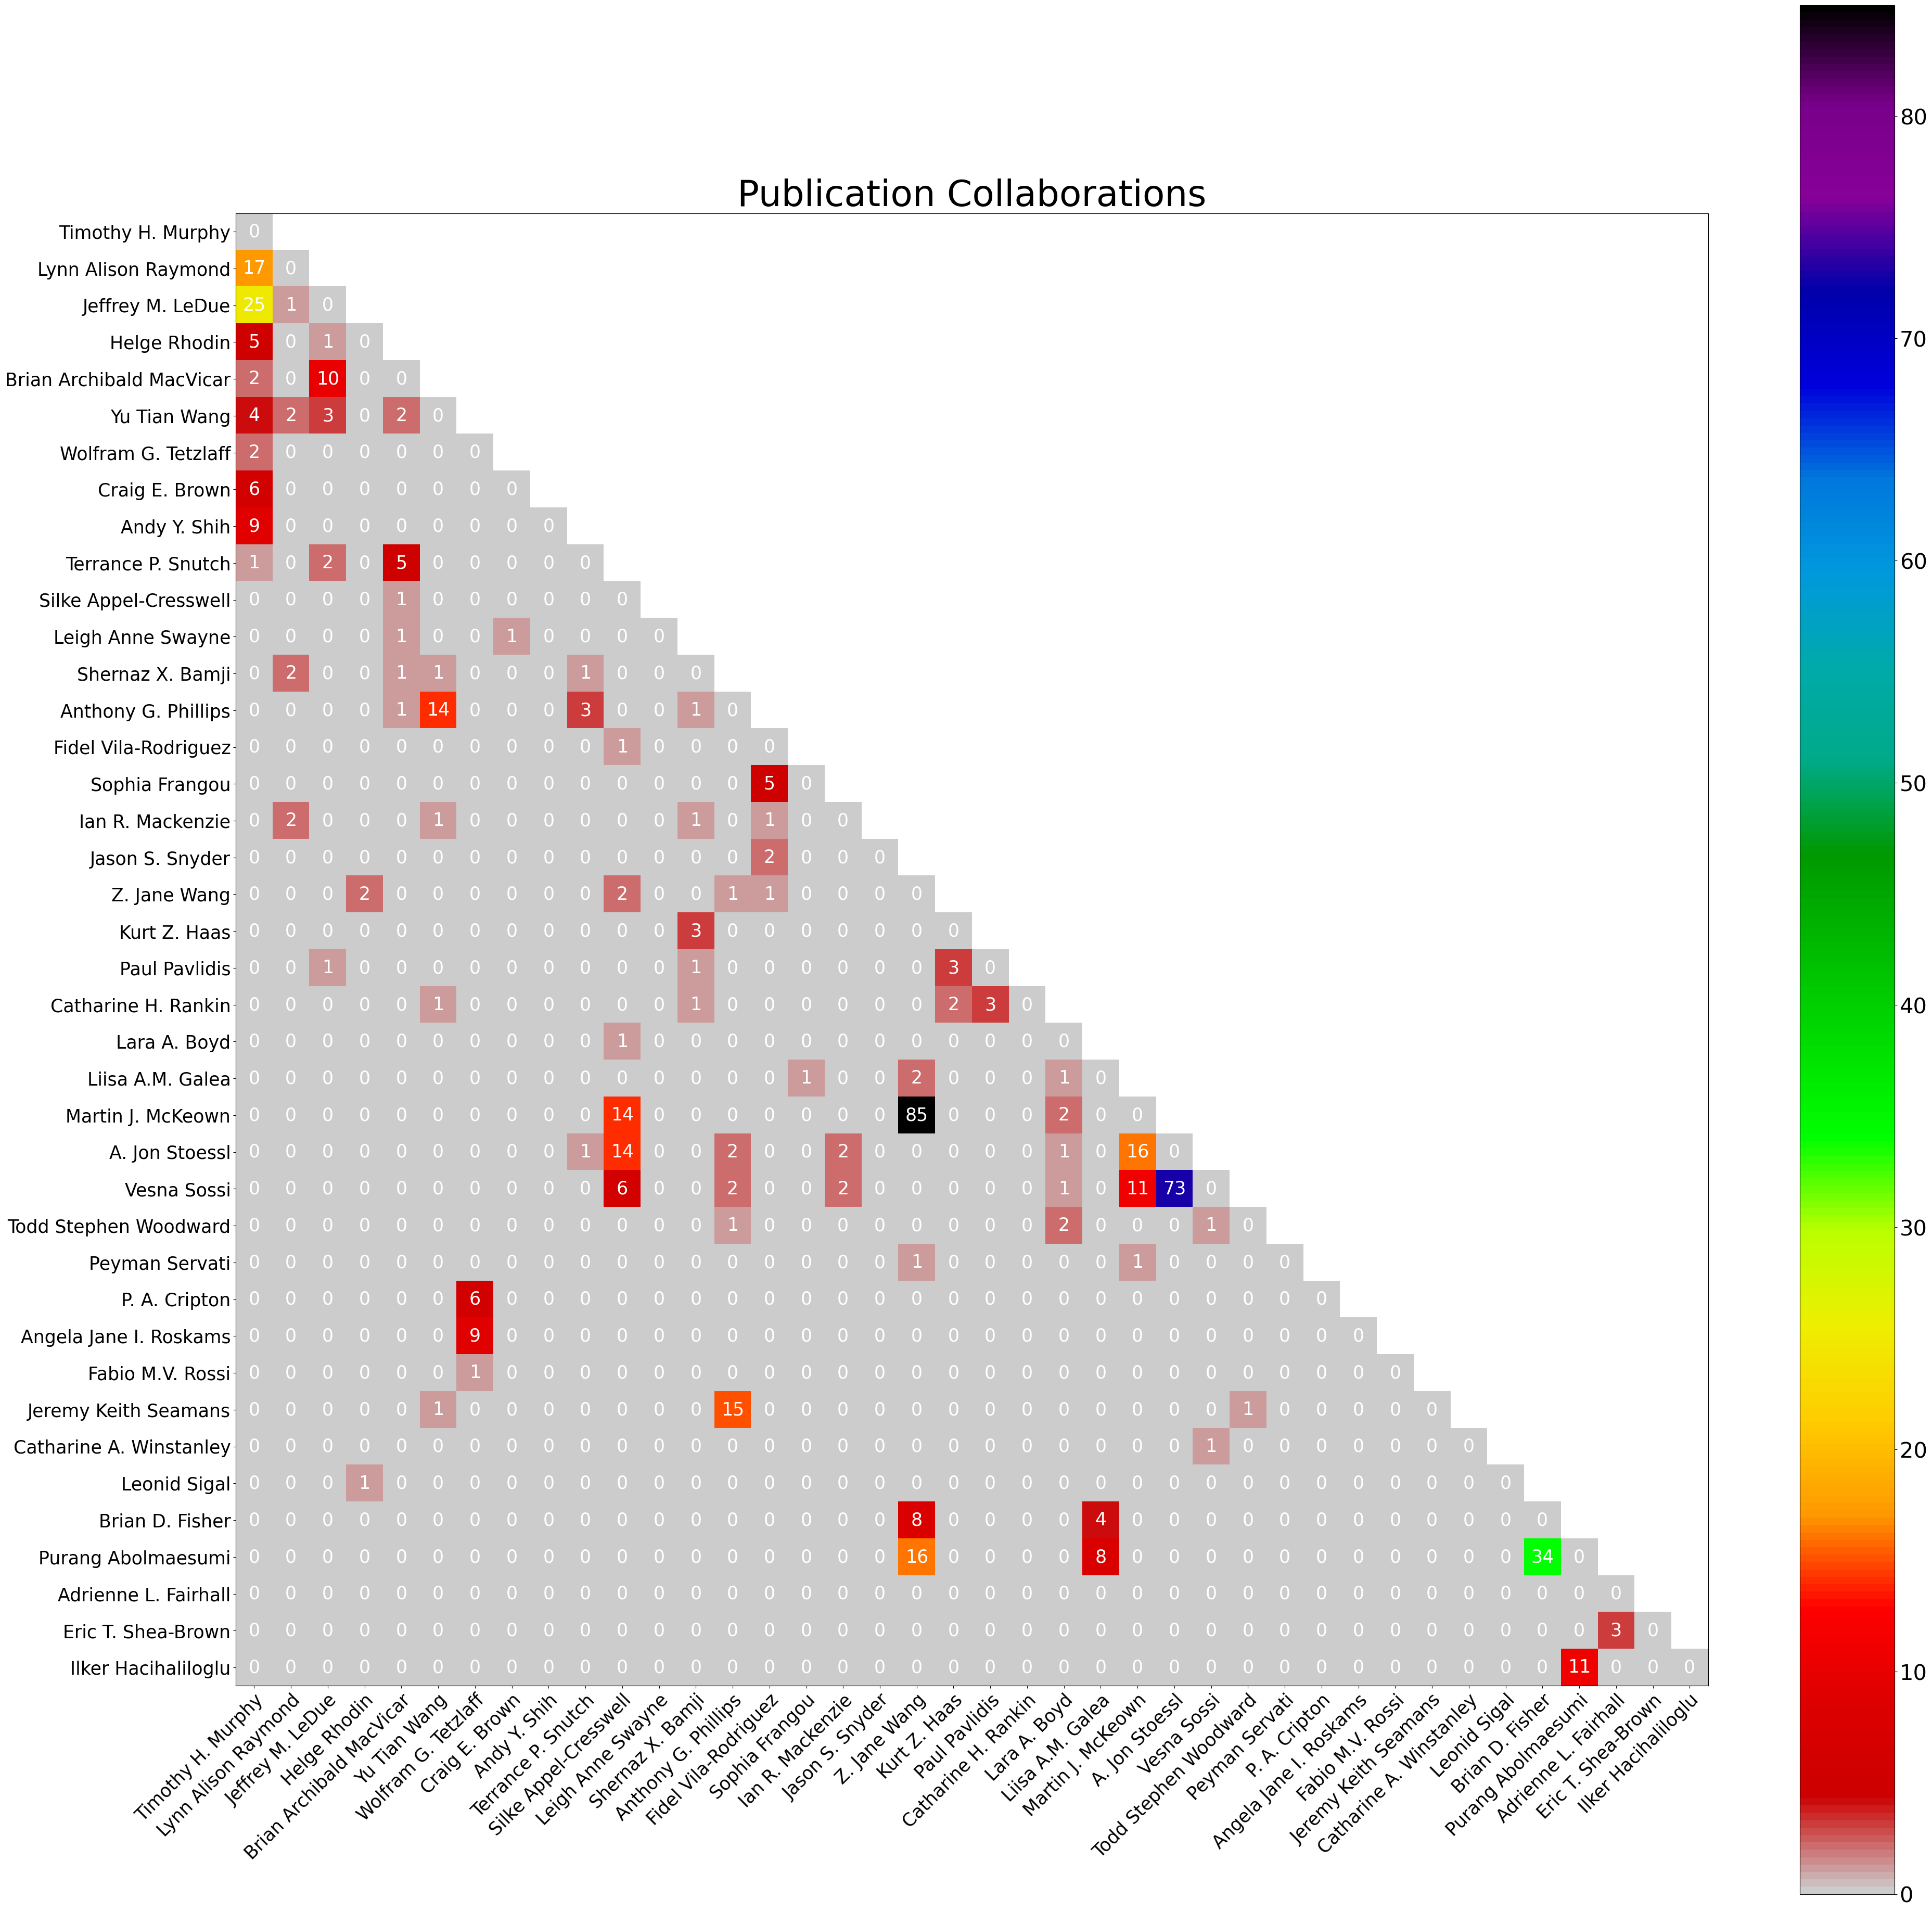

In [13]:
authors = list(collabs_dict.keys())
print(authors)
author_count=len(authors)
# Initialize array with zeros. 
collabs_array = np.zeros((author_count, author_count), dtype=int)

# Populate the array with the number of collaborations between authors
for i, athr in enumerate(authors):
    for j, name in enumerate(authors):
        if name in collabs_dict[athr].keys():
            collabs_array[i][j] = collabs_dict[athr][name]
            
# Only display the lower triangle of the matrix
mask =  np.tri(collabs_array.shape[0], k=-1)
collabs_array = np.ma.array(collabs_array, mask=mask).T

# Set up the colourmap 
cmap = CM.get_cmap('nipy_spectral') 
cmap = cmap.reversed()

### Create heatmap ###

fig = plt.figure(figsize = (author_count,author_count)) 
ax = fig.add_subplot(111)
im = ax.imshow(collabs_array, cmap=cmap, interpolation='nearest', 
               #norm=matplotlib.colors.LogNorm()            # Uncomment this if you want a logarithmic colormap
              )

# Show the ticks
ax.set_xticks(np.arange(author_count))
ax.set_yticks(np.arange(author_count))

# Label the ticks with author names - you can modify the authorname font size here
ax.set_xticklabels(authors,fontsize=25)
ax.set_yticklabels(authors, fontsize=25)

# Rotate and align tick labels.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Create numeric annotations.
for i in range(author_count):
    for j in range(author_count):
        text = ax.text(j, i, collabs_array[i, j],
                       ha="center", va="center", color="w", fontsize=25)
# Fit plot within figure        
fig.tight_layout()


# Add title - you can change the title and title font size here
ax.set_title("Publication Collaborations", fontsize = 50)

# Add the colorbar and add ticks - change colorbar label fontsize here
cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=30)

# Save the figure as PDF - you can modify the filename here. 
plt.savefig(figure_output)

plt.show()
